In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import rc_context

sc.settings.verbosity = 1

#sc.logging.print_versions()

import os 
import sys
import gc
import importlib

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = 'Arial'
sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)
sns.set_style('white', {'axes.grid' : False})


def vector(on=False):
    if on:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=False)
    else:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)
vector(False)

# Read gem files

In [2]:
files = os.popen('ls gem/*gem.gz').read().split('\n')[:-1]
files

['gem/C03637A1.lasso.bin1.Label1.gem.gz',
 'gem/C03637A2.lasso.bin1.Label1.gem.gz',
 'gem/C03637A5.lasso.bin1.Label1.gem.gz',
 'gem/C03637C3.lasso.bin1.Label1.gem.gz',
 'gem/C03637C5.lasso.bin1.Label1.gem.gz',
 'gem/C03637D3.lasso.bin1.Label1.gem.gz',
 'gem/C03637E1.lasso.bin1.Label1.gem.gz',
 'gem/C03637E2.lasso.bin1.Label1.gem.gz',
 'gem/C03637E5.lasso.bin1.Label1.gem.gz',
 'gem/C03637F1.lasso.bin1.Label1.gem.gz']

In [171]:
def gem2adata(in_put, binsize, stereopy=False, in_type='file', sep='\t'):
    import scipy.sparse as sps
    if in_type == 'file':
        df = pd.read_csv(in_put, comment='#', sep=sep)
    if in_type == 'df':
        df = in_put.copy()
    if not stereopy:
        df['x'] = df['x'].apply(lambda x: int(x/binsize)*binsize)
        df['y'] = df['y'].apply(lambda x: int(x/binsize)*binsize)
    if stereopy:
        df = stereopy_merge(df, binsize=binsize)
        
    df['index'] = df['x'].apply(str) + '_' + df['y'].apply(str) + '@' + df['geneID']
    try:
        df = df[['index', 'MIDCounts']]
    except:
        df = df[['index', 'MIDCount']]
    
    df.columns = ['index', 'MIDCounts']

    df = df.groupby('index').sum()

    df[['index', 'geneID']] = [x.split('@') for x in df.index]
    index = df['index'].unique()
    idict = dict(zip(index, range(len(index))))
    geneID = df['geneID'].unique()
    gdict = dict(zip(geneID, range(len(geneID))))

    df['index'] = df['index'].apply(lambda x: idict[x])
    df['geneID'] = df['geneID'].apply(lambda x: gdict[x])

    csr_matrix = sps.csr_matrix((df['MIDCounts'].values, (df['index'].values, df['geneID'].values)), shape=(len(index), len(geneID)))
    adata = sc.AnnData(csr_matrix)
    adata.obs[['x', 'y']] = [x.split('_') for x in index]
    adata.obs[['x', 'y']] = adata.obs[['x', 'y']].applymap(int)
    adata.obs_names = ['DNB_' + x for x in index]
    adata.var_names = geneID
    adata.obsm['spatial'] = adata.obs[['x', 'y']].values
    return adata

In [3]:
alist = list()
for file in files:
    adata = gem2adata(file, binsize=200, in_type='file')
    name = os.path.basename(file).split('.')[0]
    adata.obs['chip'] = name
    adata.obs_names = name + '@' + adata.obs['x'].astype(str) + '_' + adata.obs['y'].astype(str)
    alist.append(adata)

In [ ]:
# 202301978	TQD231057990	C03637A5	18
# 202338662	TQD231057991	C03637A1	70
# 201814325	TQD231057996	C03637A2	52
# 201808918	TQD231057995	C03637C3	46
# 202344123	TQD231057982	C03637C5	76
# 202307865	TQD231057984	C03637D3	62
# 201528238	TQD231058003	C03637E1	37
# 201518428	TQD231058005	C03637E2	22
# 201509945	TQD231058008	C03637E5	43
# 201523736	TQD231058007	C03637F1	51

In [38]:
sample = ['202338662', '201814325', '202301978', '201808918', '202344123', 
          '202307865', '201528238', '201518428', '201509945', '201523736']

for i, adata in enumerate(alist):
    adata.obs['sample'] = sample[i]
    
adata = sc.concat(alist, join='outer')
adata.write('tnbc_merge_raw_bin200.h5ad')

# QC

In [130]:
adata = sc.read_h5ad('tnbc_merge_raw_bin200.h5ad')

In [134]:
adata.var_names

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2ML1-AS1',
       'A2ML1-AS2', 'A3GALT2', 'A4GALT',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'hsa-mir-1253'],
      dtype='object', length=33136)

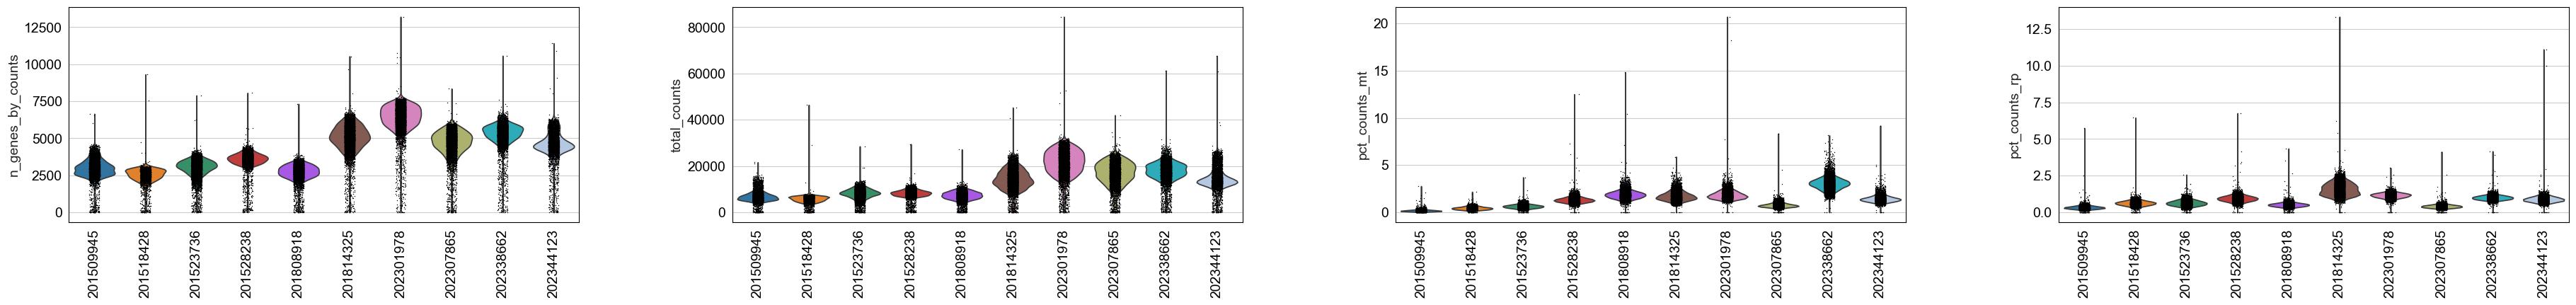

In [135]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
adata.var['rp'] = adata.var_names.str.startswith('RPL') | adata.var_names.str.startswith('RPS')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'rp'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, groupby='sample', keys=['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_rp'], rotation=90)

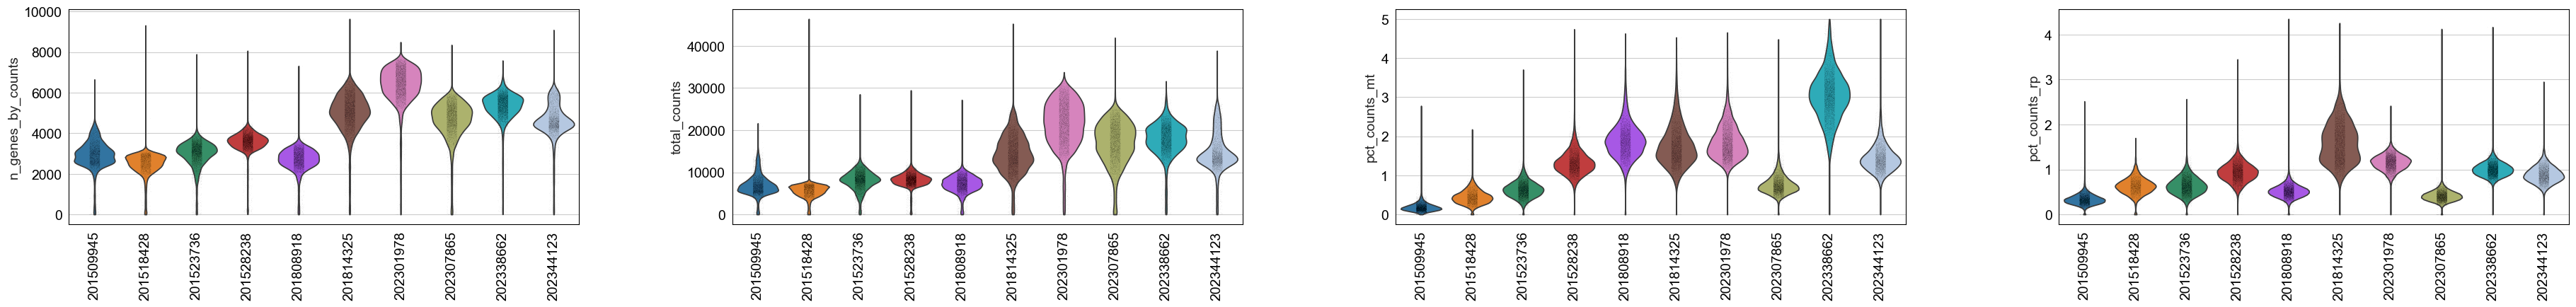

In [136]:
adata = adata[(adata.obs['n_genes_by_counts']<=10000) &
              (adata.obs['pct_counts_mt']<=5) & 
              (adata.obs['pct_counts_rp']<=5)]

plt.rc("figure", figsize=(8,4))
sc.pl.violin(adata, groupby='sample', keys=['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_rp'], rotation=90, size=0.1, rasterized=True, save='qc.pdf')

In [137]:
dv200 = [70, 52, 18, 46, 76, 62, 37, 22, 43, 51]
sample = ['202338662', '201814325', '202301978', '201808918', '202344123', 
          '202307865', '201528238', '201518428', '201509945', '201523736']
year = [x[:4] for x in sample]

group = ['>=70', '50-70', '<30', '30-50', '>=70', '50-70', '30-50', '<30', '30-50', '50-70']

cdna = [784, 572, 1232, 456, 1184, 904, 540, 280, 508, 460]

In [138]:
spots = list()
for slide in sample:
    spots.append(adata[adata.obs['sample']==slide].shape[0])
spots

[7961, 6573, 7310, 6623, 5260, 6461, 6944, 3107, 5156, 7273]

In [164]:
df = pd.DataFrame([sample, dv200, group, year, cdna, spots]).T
df.columns = ['sample', 'dv200', 'group', 'year', 'total_cdna', 'total_spots']
df.index = df['sample'].values

df['cnda(ng/mm2)'] = (df['total_cdna']/df['total_spots']/0.01).astype(float)

for name in sample:
    tmp = adata[adata.obs['sample']==name]
    md = tmp.obs['n_genes_by_counts'].median()
    df.loc[name, 'gene_count_median'] = md
    md = tmp.obs['n_genes_by_counts'].mean()
    df.loc[name, 'gene_count_mean'] = md
    total = tmp.obs['total_counts'].mean()
    df.loc[name, 'total_counts_mean'] = total
df

sample dv200  group  year total_cdna total_spots  cnda(ng/mm2)  \
202338662  202338662    70   >=70  2023        784        7961      9.848009   
201814325  201814325    52  50-70  2018        572        6573      8.702267   
202301978  202301978    18    <30  2023       1232        7310     16.853625   
201808918  201808918    46  30-50  2018        456        6623      6.885097   
202344123  202344123    76   >=70  2023       1184        5260     22.509506   
202307865  202307865    62  50-70  2023        904        6461     13.991642   
201528238  201528238    37  30-50  2015        540        6944      7.776498   
201518428  201518428    22    <30  2015        280        3107      9.011909   
201509945  201509945    43  30-50  2015        508        5156      9.852599   
201523736  201523736    51  50-70  2015        460        7273      6.324763   

           gene_count_median  gene_count_mean  total_counts_mean  
202338662             5411.0      5282.628815       17817.929531  
201814325             5087.0      4996.636239       14322.934885  
202301978             6484.0      6336.759508       21386.809166  
201808918             2749.0      2691.346520        7228.938095  
202344123             4570.5      4612.064639       14783.123954  
202307865             4777.0      4620.396997       16881.443739  
201528238             3616.0      3551.556164        8200.419355  
201518428             2571.0      2464.627937        5550.214998  
201509945             2954.0      2952.129558        6992.118503  
201523736             3098.0      2984.740547        8056.063110

In [160]:
def regplot(df, x, y, hue=None, save=None, ax=None, linewidth=0, **kwds):
    import scipy as sp
    sns.scatterplot(x=x, y=y, data=df,hue=hue, ax=ax, 
                    s=80, linewidth=linewidth, **kwds)
    sns.regplot(x=x, y=y, data=df, scatter=False, ax=ax)

    r, p = sp.stats.pearsonr(df[x], df[y])
    if ax is None:
        ax = plt.gca()
    ax.text(.05, .8, 'r={:.5f}\np={:.5g}'.format(r, p),
            transform=ax.transAxes)
    plt.legend(
        bbox_to_anchor=(1.0, 1.0),
        fontsize='small',
    )

    if save is not None:
        plt.savefig(save)
    if ax is None:
        plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


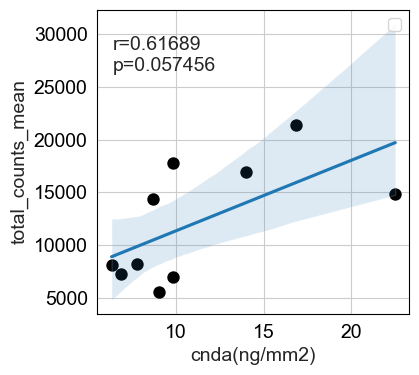

In [167]:
plt.rc("figure", figsize=(4,4))
regplot(df=df, x='cnda(ng/mm2)', y='total_counts_mean', color='black', save='cdna-total_counts.pdf')


In [168]:
df['storage_time'] = '<1y'
df.loc[df['year']!='2023', 'storage_time'] = '5-9y'

/tmp/ipykernel_3078001/3959267924.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='storage_time', y=value, palette='Set2', ax=ax[i],
/tmp/ipykernel_3078001/3959267924.py:3: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(data=df, x='storage_time', y=value, palette='Set2', ax=ax[i],
/tmp/ipykernel_3078001/3959267924.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='storage_time', y=value, palette='Set2', ax=ax[i],
/tmp/ipykernel_3078001/3959267924.py:3: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth'

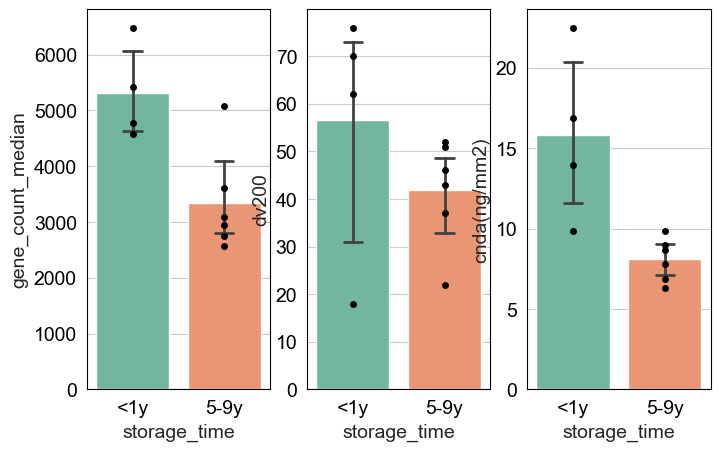

In [169]:
fig, ax = plt.subplots(1,3, figsize=(8, 5))
for i, value in enumerate(['gene_count_median', 'dv200', 'cnda(ng/mm2)']):
    sns.barplot(data=df, x='storage_time', y=value, palette='Set2', ax=ax[i],
            estimator=np.mean, errorbar="ci", capsize=.2, errwidth=2, order=['<1y', '5-9y',])
    sns.stripplot(data=df, x='storage_time', y=value, ax=ax[i], 
                  jitter=False, color='black', linewidth=0, order=['<1y', '5-9y'])
plt.savefig('year_bin200.pdf')
plt.show()    

In [149]:
stats.ttest_ind(df.loc[df['storage_time']=='<1y', 'cnda(ng/mm2)'], df.loc[df['storage_time']=='5-9y', 'cnda/spots(ng/mm2)'])

TtestResult(statistic=3.4871407049919116, pvalue=0.008232885178861518, df=8.0)

In [150]:
stats.ttest_ind(df.loc[df['storage_time']=='<1y', 'gene_count_median'], df.loc[df['storage_time']=='5-9y', 'gene_count_median'])

TtestResult(statistic=3.3779812439015626, pvalue=0.009670528199059503, df=8.0)

/tmp/ipykernel_3078001/1621095573.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='group', y=value, palette='Set2', ax=ax[i],
/tmp/ipykernel_3078001/1621095573.py:3: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(data=df, x='group', y=value, palette='Set2', ax=ax[i],
/tmp/ipykernel_3078001/1621095573.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='group', y=value, palette='Set2', ax=ax[i],
/tmp/ipykernel_3078001/1621095573.py:3: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns

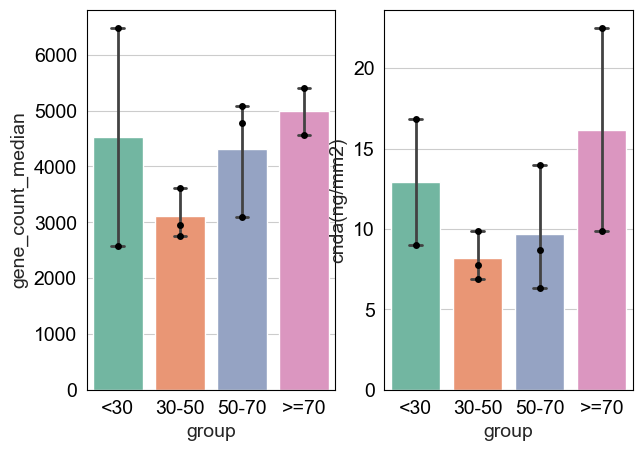

In [170]:
fig, ax = plt.subplots(1,2, figsize=(7, 5))
for i, value in enumerate(['gene_count_median', 'cnda(ng/mm2)']):
    sns.barplot(data=df, x='group', y=value, palette='Set2', ax=ax[i],
            estimator=np.mean, errorbar='ci', capsize=.2, errwidth=2, order=['<30', '30-50', '50-70', '>=70'])
    sns.stripplot(data=df, x='group', y=value, ax=ax[i], 
                  jitter=False, color='black', linewidth=0, order=['<30', '30-50', '50-70', '>=70'])
plt.savefig('group_bin200.pdf')
plt.show()    

/tmp/ipykernel_3078001/3644754019.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=adata.obs, x='sample', y=qc, width=0.8, scale='width', inner=None, palette=adata.uns['sample_colors'])
/tmp/ipykernel_3078001/3644754019.py:6: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.violinplot(data=adata.obs, x='sample', y=qc, width=0.8, scale='width', inner=None, palette=adata.uns['sample_colors'])
/tmp/ipykernel_3078001/3644754019.py:6: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=adata.obs, x='sample', y=qc, width=0.8, scale='width', inner=None, palette=adata.uns['sample_colors'])
/tmp/ipykernel_3078001/3644754019.py:6: FutureW

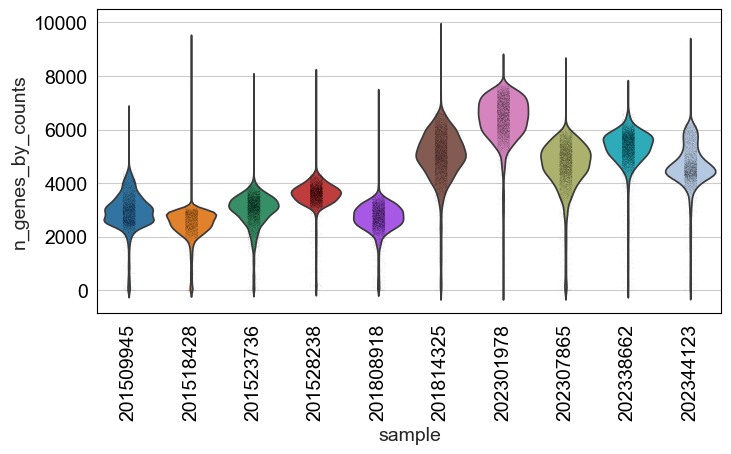

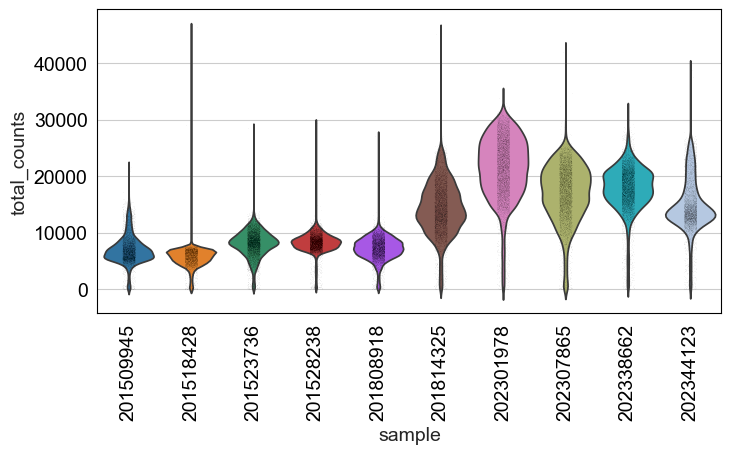

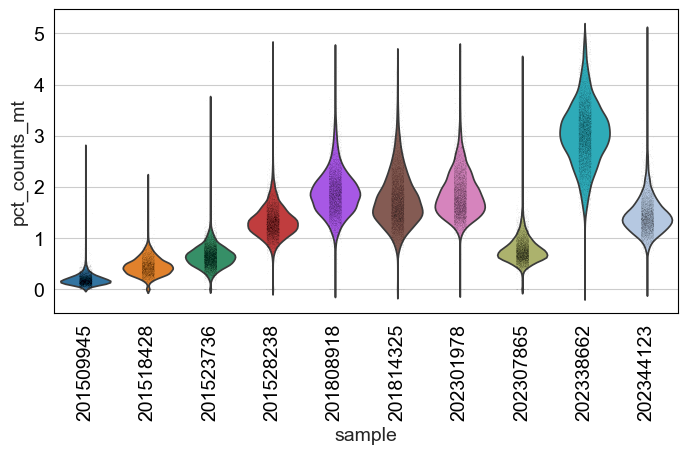

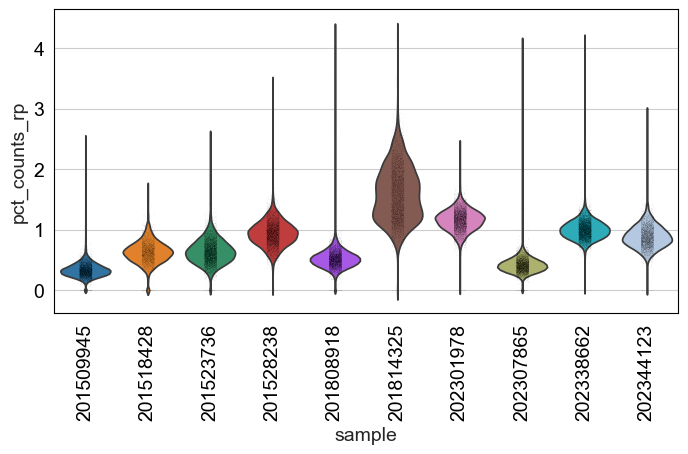

In [155]:
plt.rc("figure", figsize=(8,4))
for qc in ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_rp']:
    fig, ax = plt.subplots()

    sns.stripplot(data=adata.obs, x='sample', y=qc, size=0.1, color='black', rasterized=True, ax=ax)
    sns.violinplot(data=adata.obs, x='sample', y=qc, width=0.8, scale='width', inner=None, palette=adata.uns['sample_colors'])
    plt.xticks(rotation=90)
    plt.savefig(f'{qc}_bin200.pdf')

In [6]:
bak = adata.copy()

filtered out 4377 cells that have less than 550 genes expressed
filtered out 9646 genes that are detected in less than 50 cells


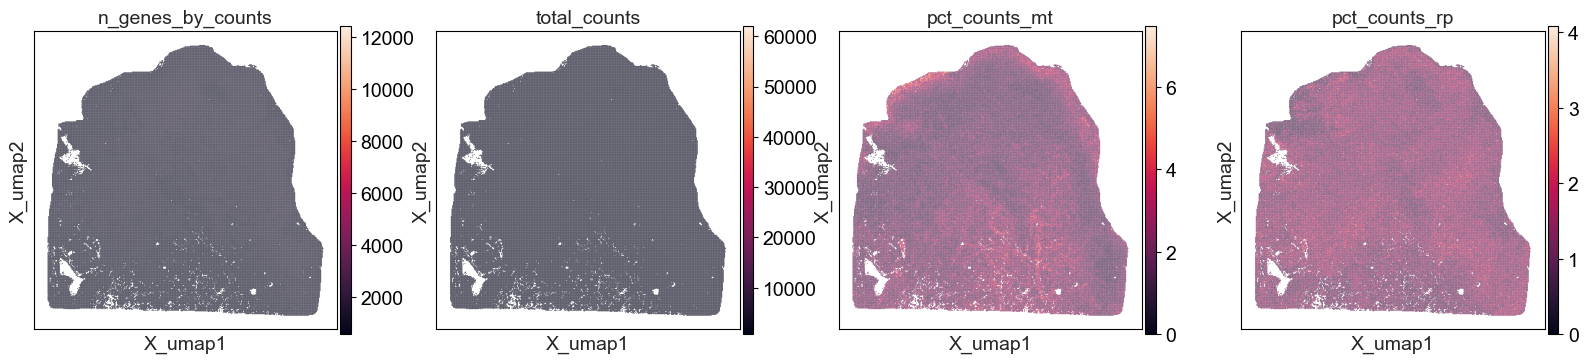

In [32]:
adata = bak.copy()
adata = sf.sc_qc(adata, min_cells=50, min_genes=550)
sc.pl.spatial(adata, color=['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_rp'], spot_size=50, basis='X_umap')

In [33]:
adata = adata[adata.obs['n_genes_by_counts']<=2000]

In [35]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:01)


In [ ]:
adata.obsm['spatial'] = adata.obsm['X_umap']
sf.cal_moran(adata)

Creating graph using `grid` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:01)


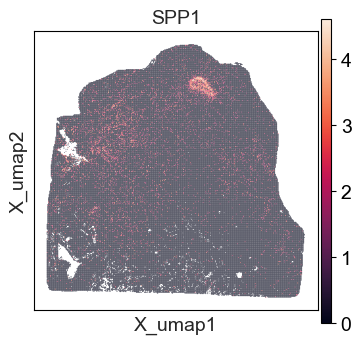

In [21]:
sc.pl.spatial(adata, color=['SPP1'], spot_size=50, basis='X_umap')

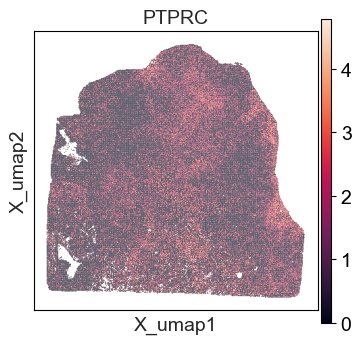

In [22]:
sc.pl.spatial(adata, color=['PTPRC'], spot_size=50, basis='X_umap')

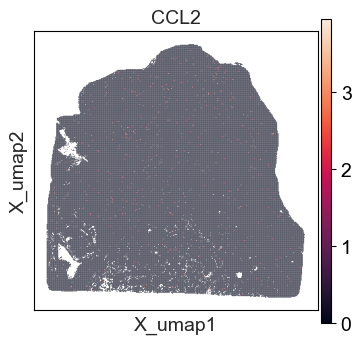

In [24]:
sc.pl.spatial(adata, color=['CCL2'], spot_size=50, basis='X_umap')

In [ ]:
min_disp=0.5
min_mean=0.05
max_mean=8

sc.pp.highly_variable_genes(adata, flavor="seurat", min_disp=min_disp, min_mean=min_mean, max_mean=max_mean)
print(adata.var['highly_variable'].sum())
sc.pl.highly_variable_genes(adata)

In [ ]:
adata.var['I'] = adata.uns['moranI']['I']
sns.scatterplot(data=adata.var, x='I', y='dispersions_norm')
plt.show()

min_I = 0.01
min_disp=2.5
((adata.var['I'] > min_I) & (adata.var['dispersions']>min_disp)).sum()

In [ ]:
adata.raw =adata

In [ ]:
adata.var['highly_variable'] = (adata.var['I'] > min_I) & (adata.var['dispersions']>min_disp)
adata = adata[:, adata.var['highly_variable']]
sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata)
sc.pl.pca_variance_ratio(adata)

In [ ]:
n_neighbors=40
n_pcs=10
res = 0.8

sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs,)
sc.tl.umap(adata)

# for res in [0.8, 1, 1.2, 1.5, 2]:
#     sc.tl.leiden(adata, resolution=res)
#     adata.obs['res_' + str(res)] = adata.obs['leiden'].copy()
sc.tl.leiden(adata, resolution=res)
adata.obs['res_' + str(res)] = adata.obs['leiden'].copy()

vector(False)
leidens = [x for x in adata.obs.columns if 'res_' in x]
sc.pl.spatial(adata, color=leidens + ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_rp'], 
              spot_size=50, basis='spatial', ncols=5, save='A02384C3_cluster.pdf')

In [116]:
sf.reloc(adata)

/home/lee/project/scanpy_func/scanpy_func.py:311: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['sample'] = adata.obs['sample'].astype('category')


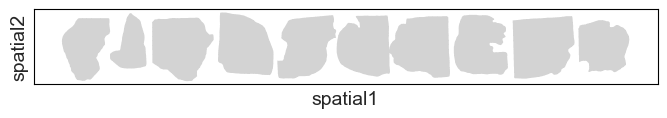

In [117]:
sc.pl.spatial(adata, spot_size=50)

In [120]:
adata.layers['counts'] = adata.X.copy()

In [121]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:05)


In [ ]:
adata.write('tnbc_merge_bin50.h5ad')

In [122]:
genes = ['PPP1R14C',
 'MTRF1L',
 'AL138733.1',
 'PCMT1',
 'RMND1',
 'PLEKHG1',
 'MTHFD1L',
 'AL160162.1',
 'ESR1',
 'LRP11',
 'ULBP2',
 'AKAP12',
 'ZBTB2',
 'IYD',
 'ARMT1',
 'MYCT1',
 'SYNE1',
 'AL080276.2',
 'AL358852.1',
 'ULBP1',
 'AL590867.3',
 'RAET1G',
 'AL355312.2',
 'NUP43',
 'AL355312.3',
 'LATS1',
 'RAET1L',
 'CCDC170',
 'RGS17',
 'AL590867.1',
 'FBXO5',
 'RAET1E',
 'ULBP3']

sc.tl.score_genes(adata, gene_list=genes)

computing score 'score'
    finished: added
    'score', score of gene set (adata.obs).
    799 total control genes are used. (0:00:08)


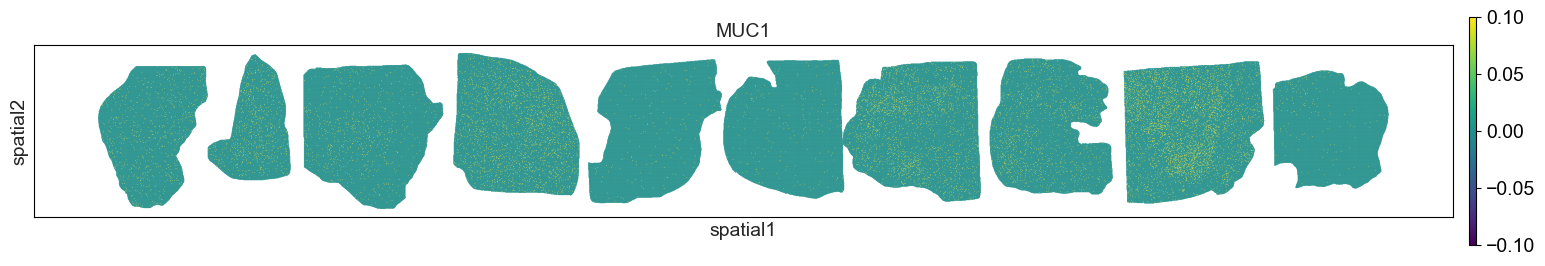

In [128]:
fig, ax = plt.subplots(figsize=(20, 3))
sc.pl.spatial(adata, color='MUC1', spot_size=80, cmap='viridis', vmax='p95', vmin=0, ax=ax)

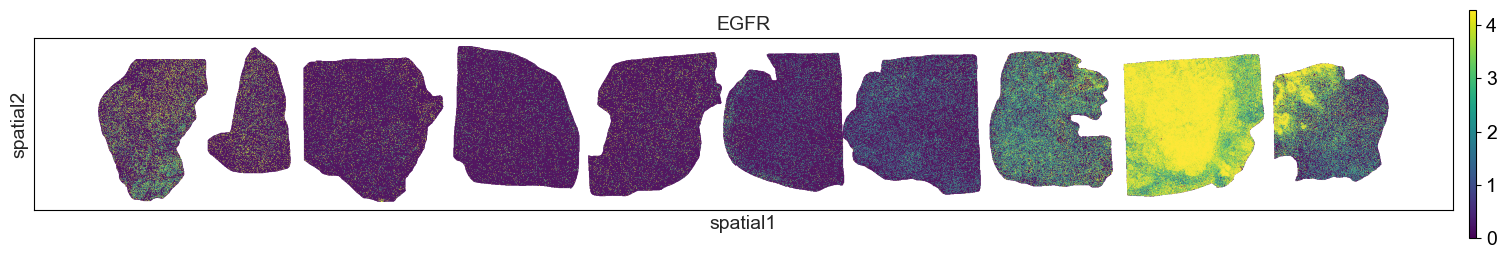

In [129]:
fig, ax = plt.subplots(figsize=(20, 3))
sc.pl.spatial(adata, color='EGFR', spot_size=80, cmap='viridis', vmax='p95', vmin=0, ax=ax)

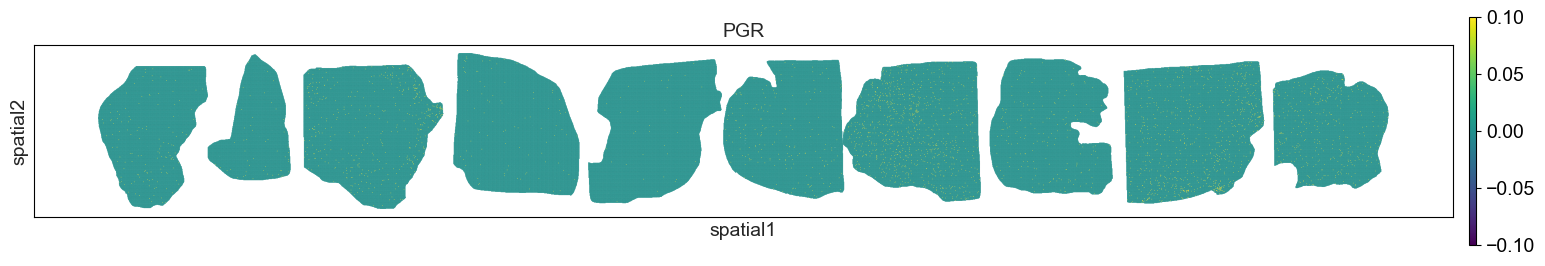

In [131]:
fig, ax = plt.subplots(figsize=(20, 3))
sc.pl.spatial(adata, color='PGR', spot_size=80, cmap='viridis', vmax='p95', vmin=0, ax=ax)

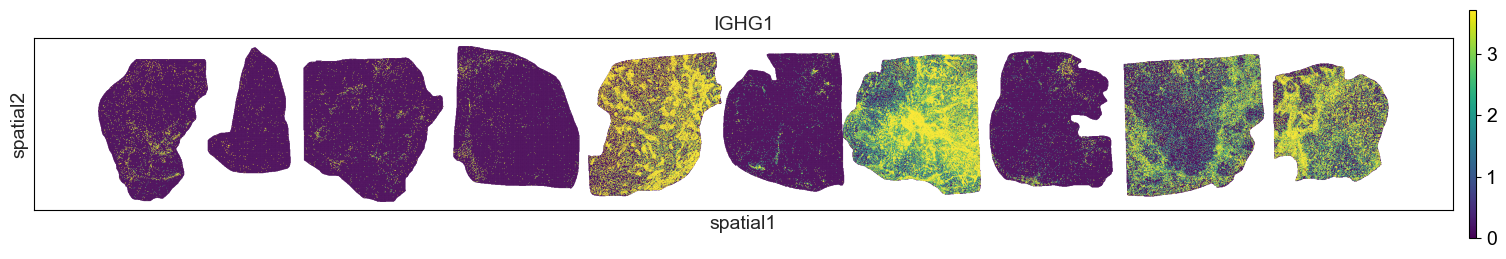

In [132]:
fig, ax = plt.subplots(figsize=(20, 3))
sc.pl.spatial(adata, color='IGHG1', spot_size=80, cmap='viridis', vmax='p95', vmin=0, ax=ax)

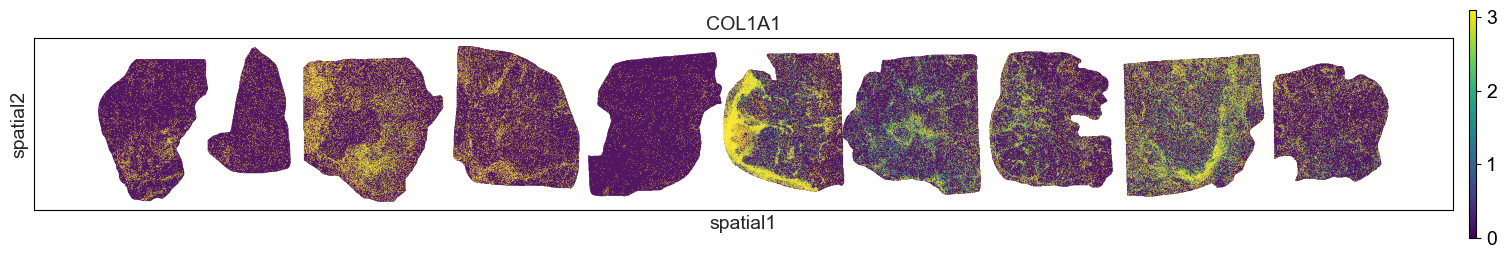

In [133]:
fig, ax = plt.subplots(figsize=(20, 3))
sc.pl.spatial(adata, color='COL1A1', spot_size=80, cmap='viridis', vmax='p95', vmin=0, ax=ax)

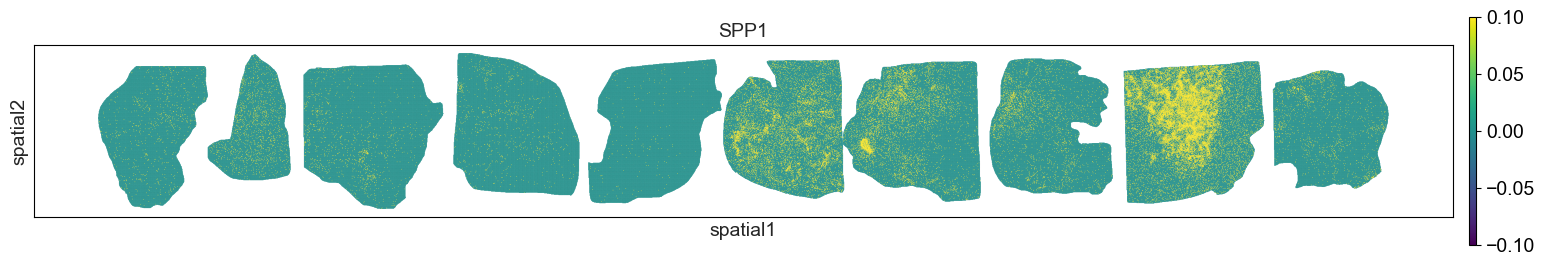

In [134]:
fig, ax = plt.subplots(figsize=(20, 3))
sc.pl.spatial(adata, color='SPP1', spot_size=80, cmap='viridis', vmax='p95', vmin=0, ax=ax)

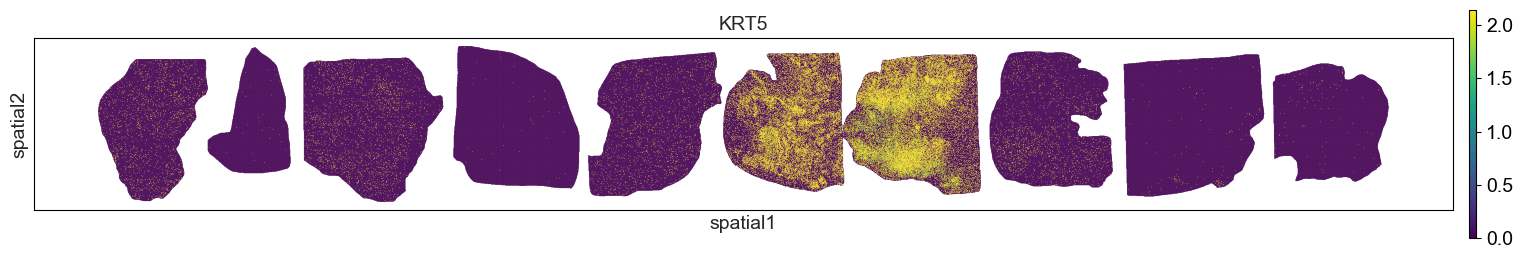

In [135]:
fig, ax = plt.subplots(figsize=(20, 3))
sc.pl.spatial(adata, color='KRT5', spot_size=80, cmap='viridis', vmax='p95', vmin=0, ax=ax)

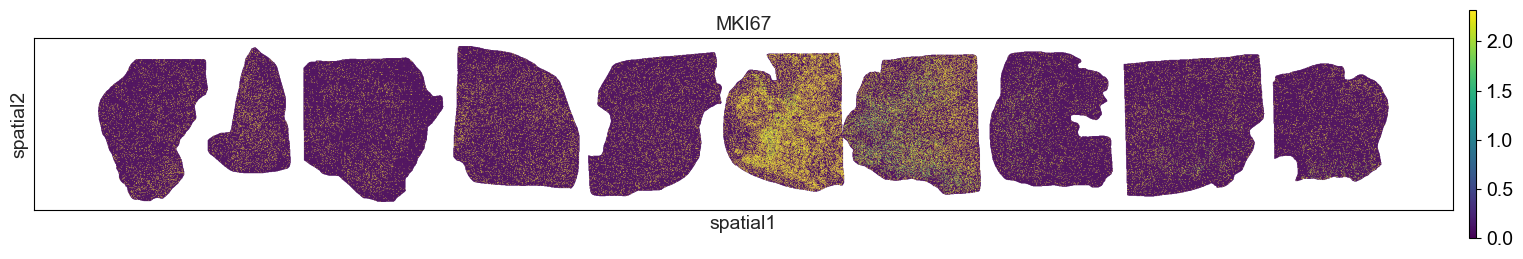

In [21]:
fig, ax = plt.subplots(figsize=(20, 3))
sc.pl.spatial(adata, color='MKI67', spot_size=80, cmap='viridis', vmax='p95', vmin=0, ax=ax)

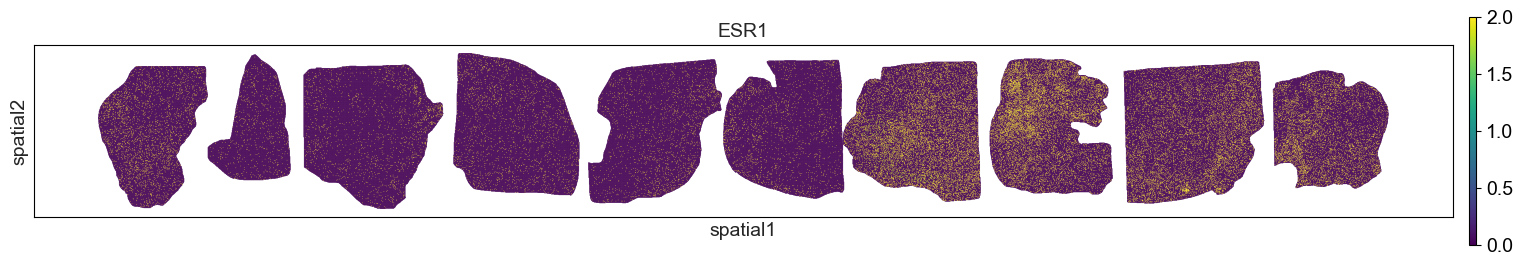

In [149]:
fig, ax = plt.subplots(figsize=(20, 3))
sc.pl.spatial(adata, color='ESR1', spot_size=80, cmap='viridis', vmax=2, vmin=0, ax=ax)

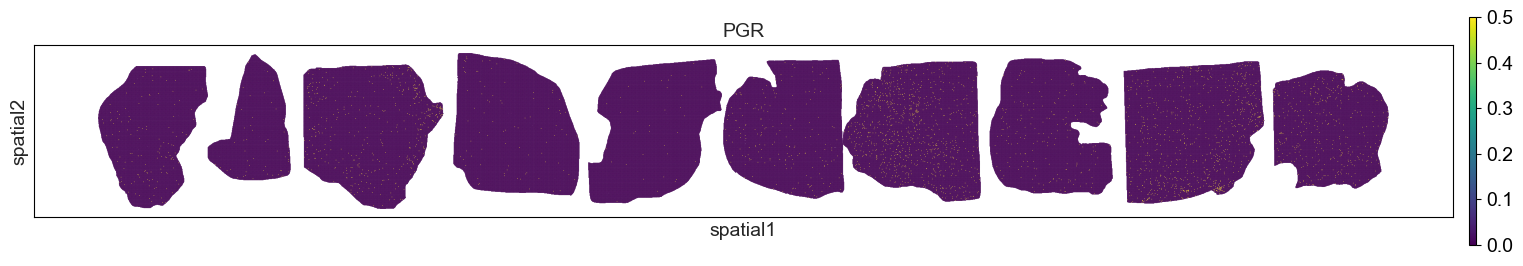

In [145]:
fig, ax = plt.subplots(figsize=(20, 3))
sc.pl.spatial(adata, color='PGR', spot_size=80, cmap='viridis', vmax=1, vmin=0, ax=ax)

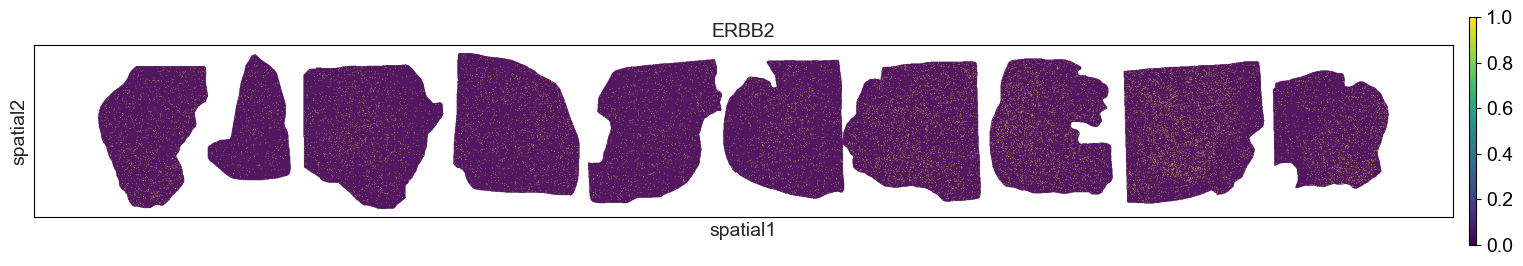

In [148]:
fig, ax = plt.subplots(figsize=(20, 3))
sc.pl.spatial(adata, color='ERBB2', spot_size=80, cmap='viridis', vmax=1, vmin=0, ax=ax)